# TP1 — Part 3: CNNs + Data Augmentation on MNIST (Rotation & Translation)

**Course:** Deep Learning for Image Analysis / Computer Vision  
**Goal:** Train a **CNN** on MNIST, **inspect its layers**, and show how **data augmentation** (rotation + translation) can improve robustness.

In Part 2, we used an MLP and **flattened** images into vectors.  
In Part 3, we use **CNNs** to exploit spatial structure **(1, 28, 28)** and we test a key idea in vision:  
> If we train with rotated/translated images, the model generalizes better to these transformations.

---
## What you will do
1. Train a baseline CNN on MNIST (no augmentation)
2. Train the same CNN with **RandomAffine** augmentation (rotation + translation)
3. Compare test accuracy on:
   - **standard MNIST test**
   - **transformed MNIST test** (rotated/translated)
---


## 0) Setup (Colab GPU)

In Colab: **Runtime → Change runtime type → GPU**  
Then run the cell below.


In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: Tesla T4


## 1) Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


## 2) Data: MNIST + Augmentations

We will create **four** dataset variants:

1. **Train (no aug)**: standard MNIST training set  
2. **Train (aug)**: MNIST with *rotation + translation*
3. **Test (standard)**: standard MNIST test set  
4. **Test (transformed)**: MNIST test set **with the same types of transforms** (to evaluate robustness)

### Augmentation used
- Rotation: up to ±35 degrees
- Translation: up to 30% of the image size

This simulates real-world variation (digits rarely appear perfectly centered).


In [3]:
torch.manual_seed(0)

# Standard transform
tfm_standard = transforms.ToTensor()

# Augmentation: rotation + translation (applied during training)
tfm_aug = transforms.Compose([
   # Todo tansformations to be applied
   transforms.RandomAffine(degrees=35, translate=(0.3, 0.3)),
   # Todo think of using RandomAffine
    transforms.ToTensor()
])

# "Transformed test" to measure robustness to these changes
tfm_test_transformed = transforms.Compose([
    # Todo same transformations as above
    transforms.RandomAffine(degrees=35, translate=(0.3, 0.3)),
    transforms.ToTensor()
])

# Datasets
train_noaug = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=tfm_standard
) # TDDO: import mnist train without augmentation

train_aug = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=tfm_aug
) # TDDO import mnist with augmentation

test_std = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=tfm_standard
) # TDDO: import mnist test without augmentation

test_trans = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=tfm_test_transformed
) # TDDO: import mnist test without augmentation

len(train_noaug), len(train_aug), len(test_std), len(test_trans)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.08MB/s]


(60000, 60000, 10000, 10000)

### Quick visualization (standard vs augmented)

If augmentation is working, you should see digits slightly rotated and shifted.


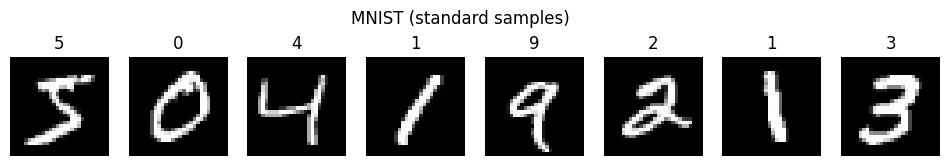

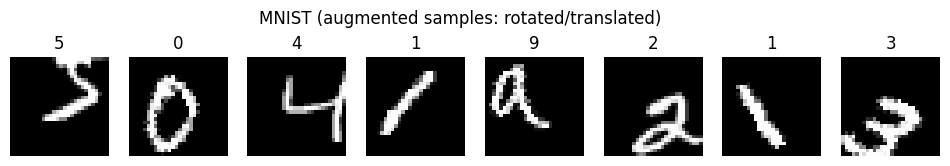

In [4]:
def show_samples(dataset, title, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(str(label))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_noaug, "MNIST (standard samples)")
show_samples(train_aug, "MNIST (augmented samples: rotated/translated)")


## 3) DataLoaders

We'll use mini-batches. If you run out of memory, reduce `batch_size`.


In [5]:
batch_size = 128

train_loader_noaug = DataLoader(train_noaug, batch_size=batch_size, shuffle=True) # TDDO : create the dataloader : we saw it in the first part
train_loader_aug = DataLoader(train_aug, batch_size=batch_size, shuffle=True) # TDDO

test_loader_std = DataLoader(test_std, batch_size=batch_size, shuffle=False)# TDDO
test_loader_trans = DataLoader(test_trans, batch_size=batch_size, shuffle=False) # TDDO


## 4) CNN model

A simple CNN for MNIST:

- Conv(1→16) + ReLU + MaxPool
- Conv(16→32) + ReLU + MaxPool
- Flatten
- FC(32×7×7 → 128) + ReLU
- FC(128 → 10)

This is intentionally small so it trains quickly on Colab.


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10) # TDDO :  number of classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
model


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 5) Training & evaluation utilities

We use:
- Loss: `CrossEntropyLoss` (10 classes)
- Optimizer: `Adam`

We'll train the same architecture twice:
1) on standard MNIST (no aug)
2) on augmented MNIST (rotation + translation)


In [8]:
criterion = nn.CrossEntropyLoss() # TODO loss function

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

# TODO:  before evaluating the model
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


## 6) Train baseline CNN (no augmentation)

You can increase `epochs` if you want


In [10]:
def train_model(train_loader, epochs=20, lr=1e-3):
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        va_loss, va_acc = evaluate(model, test_loader_std)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(f"Epoch {epoch}/{epochs} | train_loss={tr_loss:.4f} train_acc={tr_acc:.3f} | test_std_acc={va_acc:.3f}")
    return model, history

epochs = 20
lr = 1e-3
cnn_noaug, hist_noaug = train_model(train_loader_noaug, epochs=epochs, lr=lr) # TDDO : train_model on the non-augmented data, choose a good learning rate


Epoch 1/20 | train_loss=0.2918 train_acc=0.916 | test_std_acc=0.972
Epoch 2/20 | train_loss=0.0739 train_acc=0.977 | test_std_acc=0.984
Epoch 3/20 | train_loss=0.0491 train_acc=0.984 | test_std_acc=0.986
Epoch 4/20 | train_loss=0.0373 train_acc=0.989 | test_std_acc=0.988
Epoch 5/20 | train_loss=0.0296 train_acc=0.991 | test_std_acc=0.990
Epoch 6/20 | train_loss=0.0246 train_acc=0.992 | test_std_acc=0.990
Epoch 7/20 | train_loss=0.0200 train_acc=0.994 | test_std_acc=0.989
Epoch 8/20 | train_loss=0.0168 train_acc=0.995 | test_std_acc=0.989
Epoch 9/20 | train_loss=0.0139 train_acc=0.995 | test_std_acc=0.989
Epoch 10/20 | train_loss=0.0116 train_acc=0.996 | test_std_acc=0.991
Epoch 11/20 | train_loss=0.0093 train_acc=0.997 | test_std_acc=0.990
Epoch 12/20 | train_loss=0.0101 train_acc=0.997 | test_std_acc=0.990
Epoch 13/20 | train_loss=0.0071 train_acc=0.998 | test_std_acc=0.990
Epoch 14/20 | train_loss=0.0068 train_acc=0.998 | test_std_acc=0.990
Epoch 15/20 | train_loss=0.0059 train_acc=0

## 7) Train CNN with augmentation (rotation + translation)

Augmentation often makes training harder (samples are more varied), but increases robustness.


In [11]:
cnn_aug, hist_aug = train_model(train_loader_aug, epochs, lr) # TDDO : train_model on the augmented data, choose a good learning rate

Epoch 1/20 | train_loss=1.2531 train_acc=0.579 | test_std_acc=0.861
Epoch 2/20 | train_loss=0.5839 train_acc=0.817 | test_std_acc=0.897
Epoch 3/20 | train_loss=0.4318 train_acc=0.866 | test_std_acc=0.948
Epoch 4/20 | train_loss=0.3535 train_acc=0.891 | test_std_acc=0.955
Epoch 5/20 | train_loss=0.3168 train_acc=0.902 | test_std_acc=0.954
Epoch 6/20 | train_loss=0.2896 train_acc=0.910 | test_std_acc=0.960
Epoch 7/20 | train_loss=0.2614 train_acc=0.917 | test_std_acc=0.964
Epoch 8/20 | train_loss=0.2412 train_acc=0.924 | test_std_acc=0.963
Epoch 9/20 | train_loss=0.2302 train_acc=0.927 | test_std_acc=0.964
Epoch 10/20 | train_loss=0.2105 train_acc=0.933 | test_std_acc=0.967
Epoch 11/20 | train_loss=0.2054 train_acc=0.936 | test_std_acc=0.971
Epoch 12/20 | train_loss=0.1961 train_acc=0.938 | test_std_acc=0.969
Epoch 13/20 | train_loss=0.1870 train_acc=0.942 | test_std_acc=0.971
Epoch 14/20 | train_loss=0.1796 train_acc=0.943 | test_std_acc=0.973
Epoch 15/20 | train_loss=0.1729 train_acc=0

## 8) Evaluate robustness

We evaluate both models on:
- Standard MNIST test set
- Transformed MNIST test set (rotated/translated)

A robust model should lose **less accuracy** on the transformed test set.


In [12]:
noaug_std_loss, noaug_std_acc = evaluate(cnn_noaug, test_loader_std) # TDDO : evaluate on standard test set
noaug_tr_loss,  noaug_tr_acc  = evaluate(cnn_noaug, test_loader_trans) # TODO
aug_std_loss,   aug_std_acc   = evaluate(cnn_aug, test_loader_std) # TODO
aug_tr_loss,    aug_tr_acc    = evaluate(cnn_aug, test_loader_trans) # TODO
print("=== Baseline CNN (no augmentation) ===")
print(f"Test (standard):    acc={noaug_std_acc:.3f}")
print(f"Test (transformed): acc={noaug_tr_acc:.3f}")
print()
print("=== CNN trained with augmentation ===")
print(f"Test (standard):    acc={aug_std_acc:.3f}")
print(f"Test (transformed): acc={aug_tr_acc:.3f}")


=== Baseline CNN (no augmentation) ===
Test (standard):    acc=0.989
Test (transformed): acc=0.275

=== CNN trained with augmentation ===
Test (standard):    acc=0.979
Test (transformed): acc=0.956


### Plot training curves (optional)

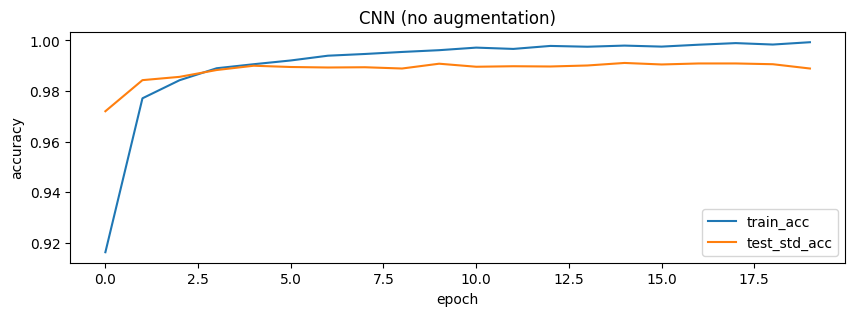

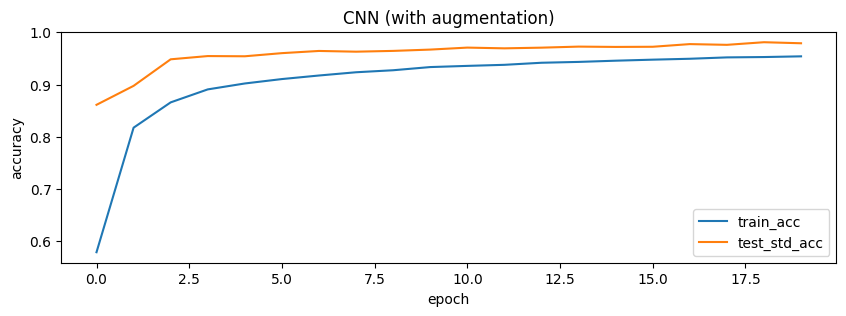

In [13]:
def plot_hist(hist, title):
    plt.figure(figsize=(10, 3))
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="test_std_acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

plot_hist(hist_noaug, "CNN (no augmentation)")
plot_hist(hist_aug, "CNN (with augmentation)")


## 9) Visualizing CNN layers

We will look at:
1. **First-layer convolution filters** (weights of Conv1)
2. **Feature maps (activations)** for a single image

This helps you *see* what the CNN learns.


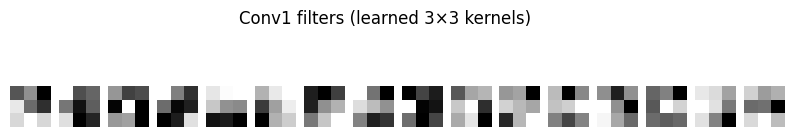

In [14]:
def show_conv1_filters(model, max_filters=16):
    conv1 = None
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            conv1 = layer
            break
    W = conv1.weight.detach().cpu()  # (out_channels, in_channels, kH, kW)

    n = min(W.shape[0], max_filters)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(W[i, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Conv1 filters (learned 3×3 kernels)")
    plt.show()

show_conv1_filters(cnn_aug)


### Feature maps (activations)

We take **one test image**, pass it through the CNN, and visualize outputs after each convolution layer.


In [15]:
@torch.no_grad()
def get_activations(model, x):
    activations = []
    cur = x
    for layer in model.features:
        cur = layer(cur)
        if isinstance(layer, nn.Conv2d):
            activations.append(cur.detach().cpu())
    return activations

# One sample from the standard test set
img, label = test_std[0]
x = img.unsqueeze(0).to(device)

acts = get_activations(cnn_aug, x)

print("Label:", label)
print("Activation shapes:", [a.shape for a in acts])


Label: 7
Activation shapes: [torch.Size([1, 16, 28, 28]), torch.Size([1, 32, 14, 14])]


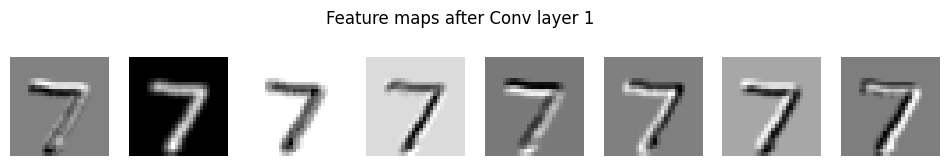

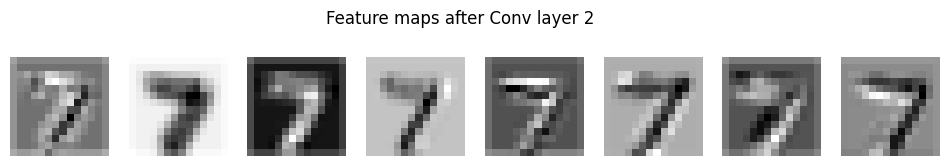

In [16]:
def show_feature_maps(activation, title, max_maps=8):
    C = activation.shape[1]
    n = min(C, max_maps)
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(activation[0, i], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

for idx, act in enumerate(acts, start=1):
    show_feature_maps(act, f"Feature maps after Conv layer {idx}", max_maps=8)


## 10) Final reflection

1. Compare **standard test accuracy** vs **transformed test accuracy** for both models. What do you notice?

**Answer:**
* Baseline CNN (no augmentation): high on standard ($\approx$0.99), very low on transformed ($\approx$0.28).
* CNN with augmentation: slightly lower on standard ($\approx$0.98), much higher on transformed ($\approx$0.96).

So, augmentation trades a tiny bit of standard accuracy for much better robustness.

2. Why does augmentation help on the transformed test set?

**Answer:** Because the model sees rotated/shifted digits during training, it learns to recognize digits regardless of position or orientation.

3. Do we always expect augmentation to improve standard test accuracy? Why/why not?

**Answer:** Not necessarily. Augmentation can slightly reduce accuracy on standard images because the model learns more general patterns instead of memorizing exact positions. Its main benefit is robustness to variations.

**Conclusion:** In the next LAB(2), we will go deeper into CNN architectures, and you should see further accuracy improvements.
